In [1]:
import tensorflow as tf
import cv2
import glob
import random
import numpy as np
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Preprocess masks

### marker-to-mask converter

In [2]:
def make_mask(marker_string, nv, nh):
    # initial mask is empty 1D array
    mask = np.zeros(nv * nh)
    
    # if markers exist, add detect part according to markers
    if len(marker_string) > 0:
        markers = np.array(marker_string.split(' ')).reshape(-1, 2)
        for marker in markers:
            start = int(marker[0])
            length = int(marker[1])
            mask[start: start+length] = 1.0
            
    mask = np.reshape(mask, (nv, nh))

    return mask            

### extract the first N image IDs and their masks

In [3]:
N = 1000
D0 = 256
D1 = 1600

train_mask_file = "data/train.csv"

with open(train_mask_file, "r", newline="") as f:
    reader = csv.reader(f)
    header = next(reader)
    print("CSV header: {}".format(header))
    
    masks = dict()
    for i, row in enumerate(reader):
        if i < N:
            # read image id and defect type
            img_id, defect_type = row[0].split('.jpg_')
        
            # process mask
            mask_marker_string = row[1]
            mask = make_mask(mask_marker_string, D0, D1)
        
            if img_id in masks:
                # if "masks" already has this image's mask(s), add this mask to the right channel
                masks[img_id][:, :, int(defect_type) - 1] = mask
            else:
                # if "masks" doesn't contain this image's info, create a 4-channel mask with zeros
                masks[img_id] = np.zeros((D0, D1, 4))  # dict({defect_type: mask})

CSV header: ['ImageId_ClassId', 'EncodedPixels']


In [4]:
random.seed(2)
img_id_0 = random.choice(list(masks.keys()))
print(img_id_0)
print(masks[img_id_0])

052cc2a0f
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


# Preprocess training images

In [5]:
train_img_dir = 'data/train_images/'
train_img_suffix = '.jpg'

def get_image(img_id):
    image_path = train_img_dir + img_id + train_img_suffix
    print(image_path)
    # import image
    image = mpimg.imread(image_path)
    # pick just one channel and normalize
    image = tf.cast(image[:, :, 0], tf.float32)/255.0
    return image

image_0 = get_image(img_id_0)

data/train_images/052cc2a0f.jpg


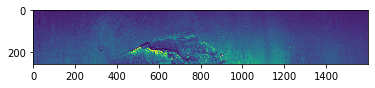

In [6]:
plt.imshow(image_0)

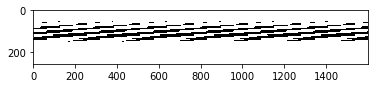

In [7]:
plt.imshow(masks[img_id_0])